# Introduction

> Liver segmentation plays a pivotal role in numerous medical imaging applications, including the diagnosis and treatment planning for liver cancer. In this project implementation we used the process of liver segmentation utilizing a U-Net architecture. Segmentation can be a complex task, particularly when working with medical images. These images may exhibit varying qualities, and the structures of interest can manifest differently in different patients. Nonetheless, recent advancements in deep learning have made it possible to achieve high accuracy in various segmentation tasks.

# Import Libraries

In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
#gpu = GPUs[0]

from google.colab import drive
drive.mount('/content/drive')

import os
import io
import random
import nibabel
import numpy as np
import nibabel as nib
import tensorflow as tf
from nibabel import load
import matplotlib.pyplot as plt
from keras.utils import Sequence
from IPython.display import Image, display
from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
import math
import glob
from matplotlib import pyplot as plt
%matplotlib inline

  Preparing metadata (setup.py) ... done
Mounted at /content/drive


# Load Dataset

**Dataset**

> * For developing model, we are using a dataset publicly available from the IRCAD research center in France.
* The 3D-IRCADb-01 database is composed of the 3D CT-scans of 10 women and 10 men with hepatic tumours in 75% of cases.
* The 20 folders correspond to 20 different patients, which can be downloaded individually or conjointly. The table below provides information on the image, such as liver size (width, depth, height) or the location of tumours according to Couninaud’s segmentation.
* It also indicates the major difficulties liver segmentation software may encounter due to the contact with neighbouring organs, an atypical shape or density of the liver, or even artefacts in the image.

**3D-IRCADb-01 folder**
> * These folders are called “3D-IRCADb-1-number” (the number varying between 01 and 20).. These folders are called “3D-IRCADb-01-number” (the number varying between 01 and 20).
* Each “3D-IRCADb-01-number” folder contains 4 sub-folders called “PATIENT_DICOM”, “LABELLED_DICOM”, “MASKS_DICOM” and “MESHES_VTK”.
* These folders respectively contain the anonymized patient image in DICOM format, the labelled image corresponding to the various zones of interest segmented in DICOM format, a new set of sub-folders corresponding to the names of the various segmented zones of interest containing the DICOM image of each mask, and finally, all the files corresponding to surface meshes of the various zones of interest in VTK format.

https://www.ircad.fr/research/data-sets/liver-segmentation-3d-ircadb-01/

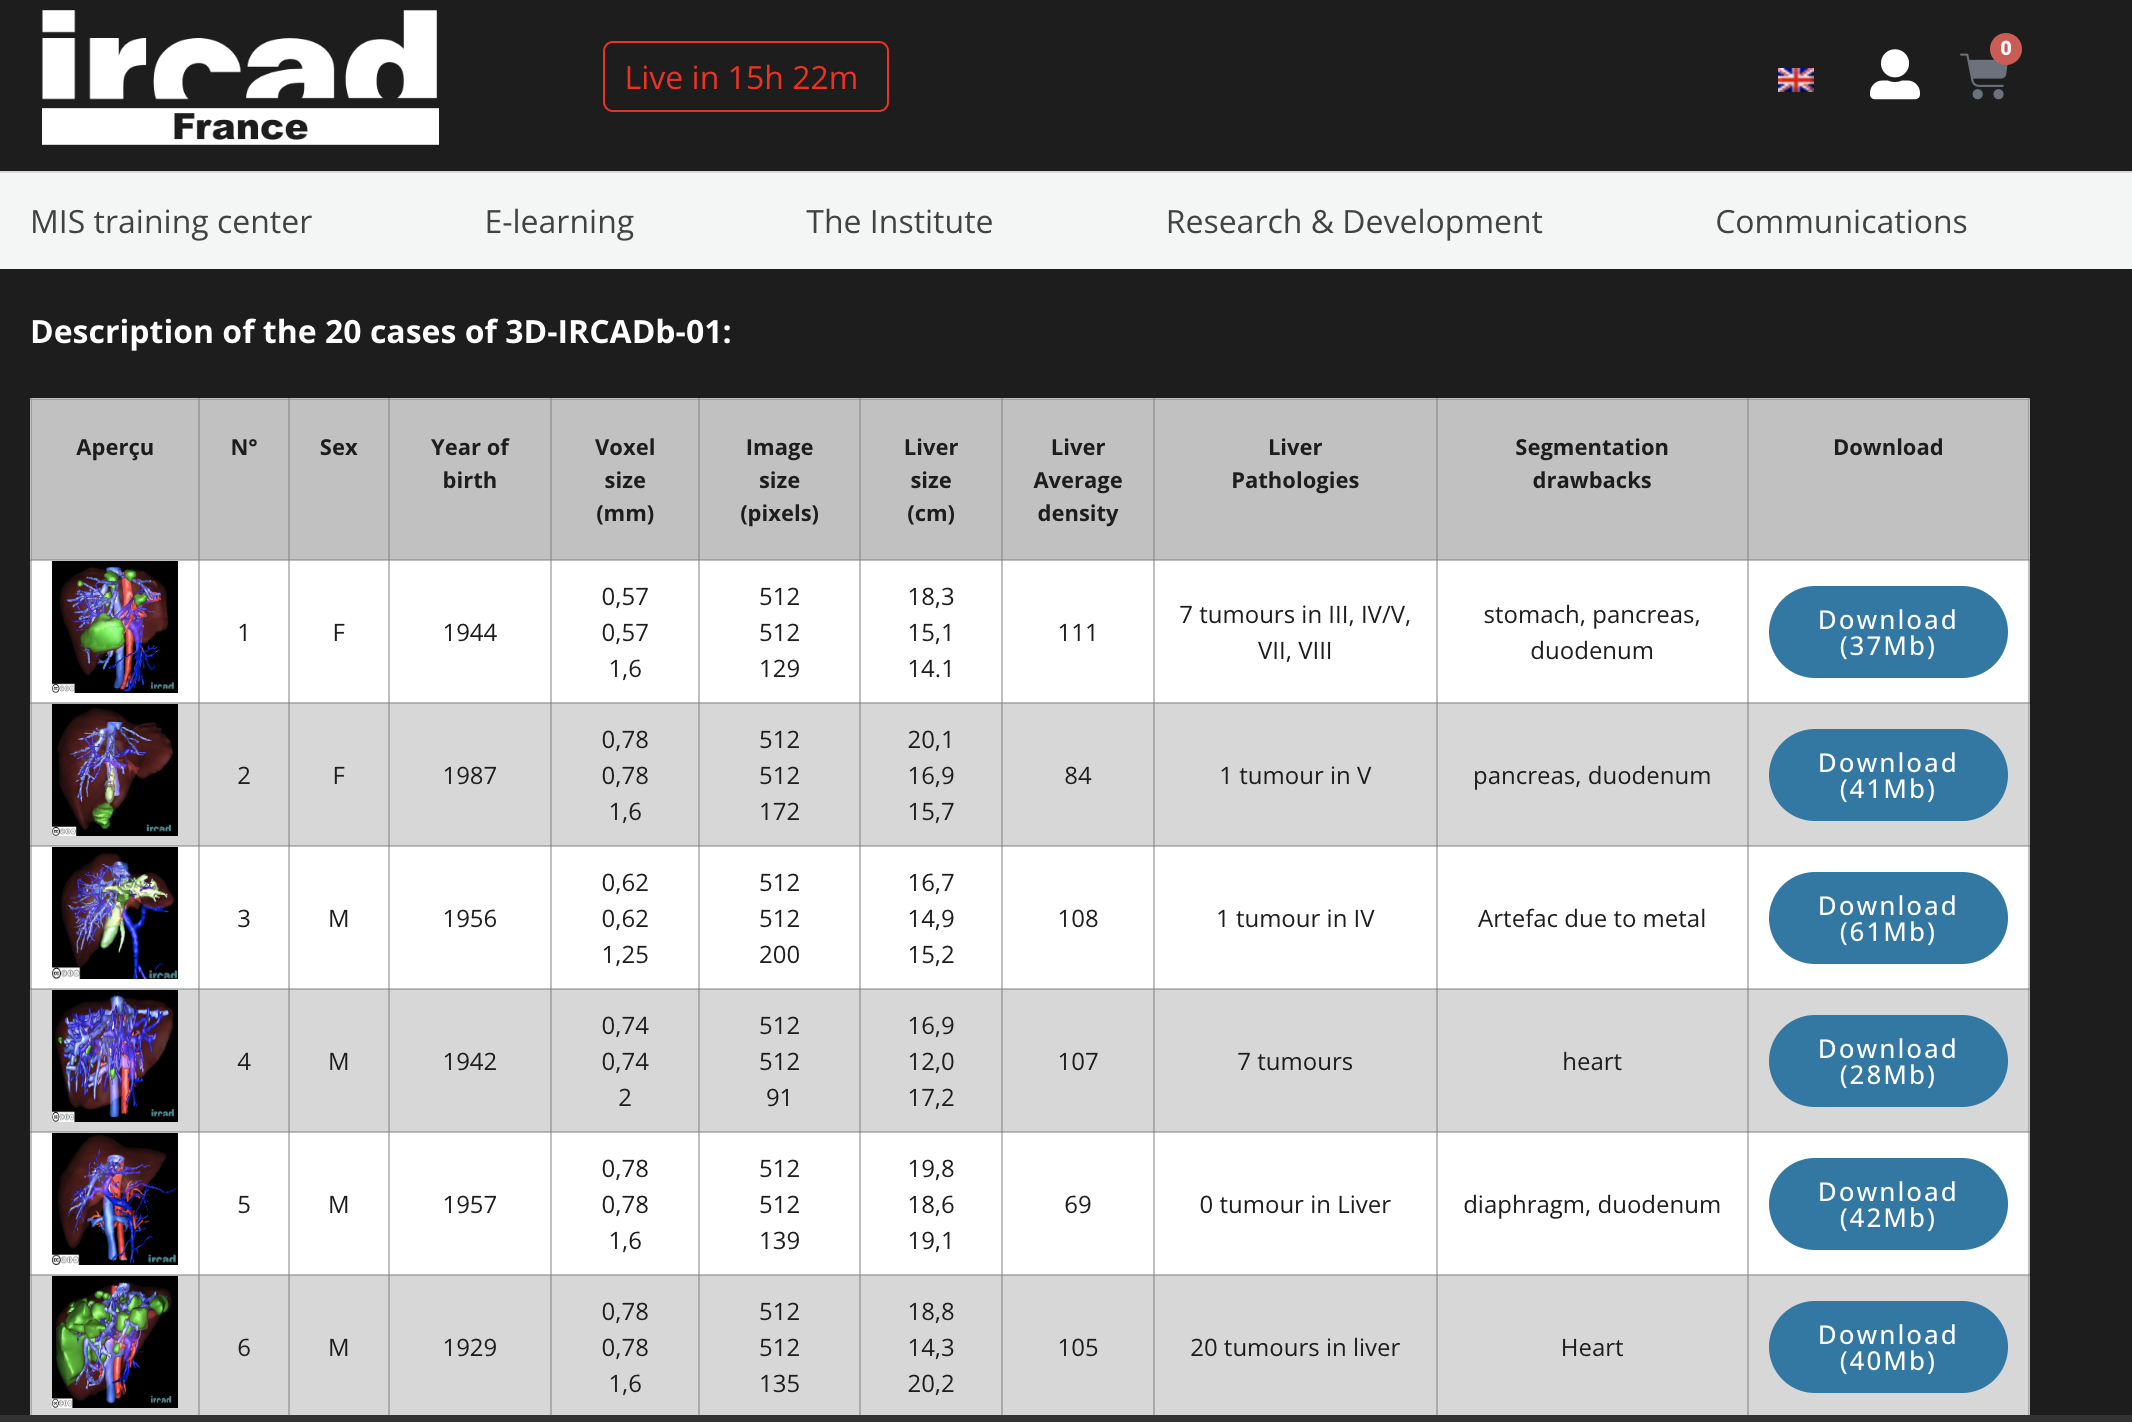

In [3]:
data_path = '/content/drive/My Drive/Image_CT_Segmentation/Dataset/dataset'

In [5]:
ff_train = glob.glob('/content/drive/My Drive/Image_CT_Segmentation/Dataset/dataset/train/*')
ff_test = glob.glob('/content/drive/My Drive/Image_CT_Segmentation/Dataset/dataset/test/*')

# Data Introduction

In [6]:
print(len(ff_train))
print(len(ff_test))

30
10


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
test_image1=nib.load(ff_train[17]).get_fdata()
print(test_image1.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape.
test_image1=scaler.fit_transform(test_image1.reshape(-1, test_image1.shape[-1])).reshape(test_image1.shape)

1.0


In [8]:
test_mask=nib.load(ff_test[1]).get_fdata()
test_mask=test_mask.astype(np.uint8)

In [9]:
print(np.unique(test_mask))

[0 1]


In [10]:
test_image1.shape

(512, 512, 200)

In [11]:
test_mask.shape

(512, 512, 124)

<ipython-input-5-c48a890ac95c>:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  a = a.get_data()


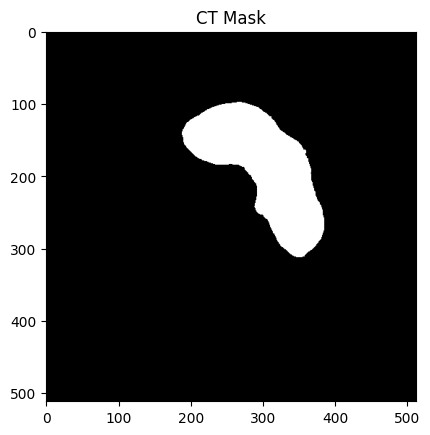

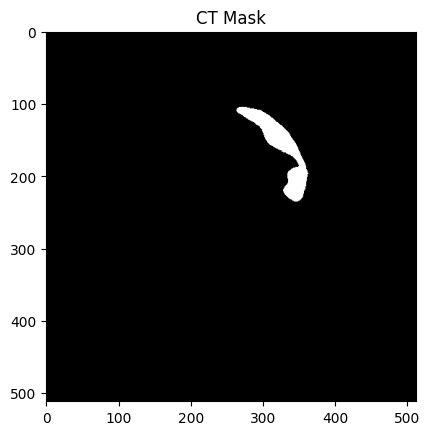

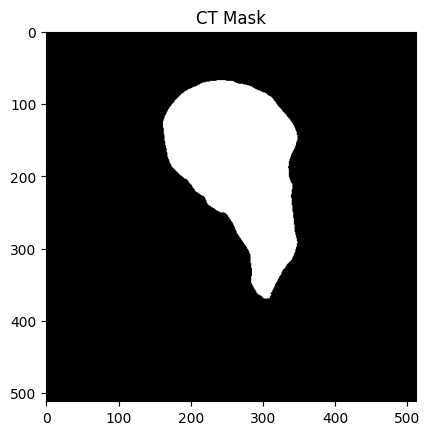

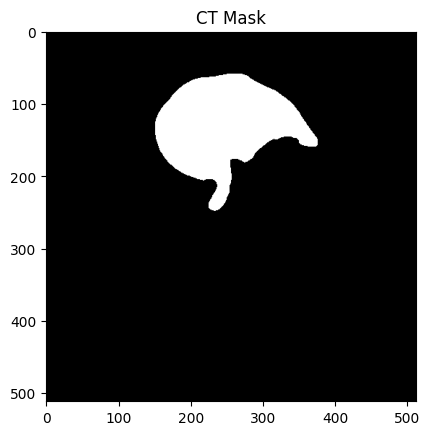

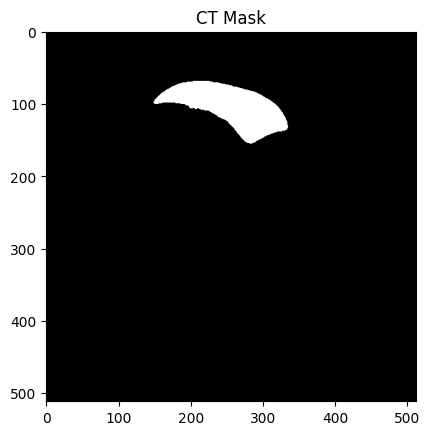

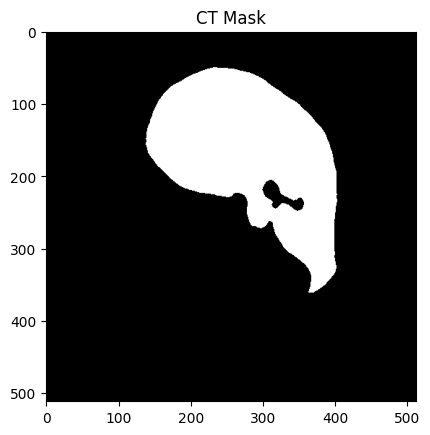

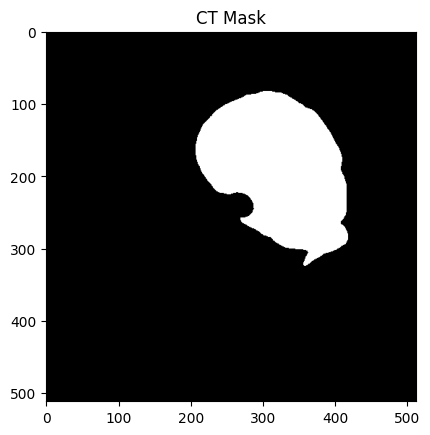

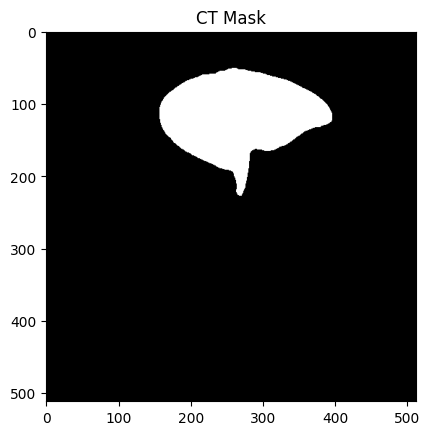

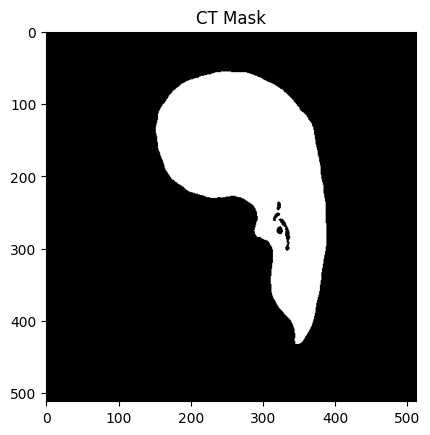

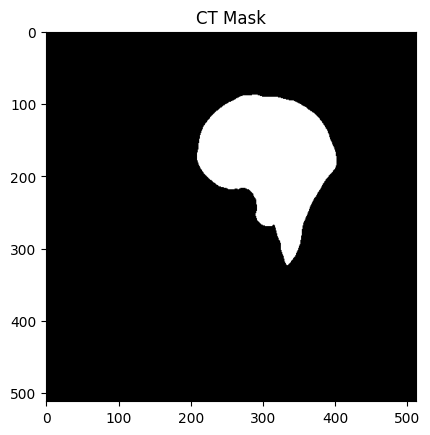

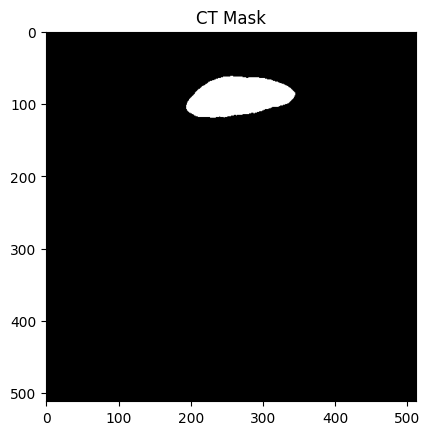

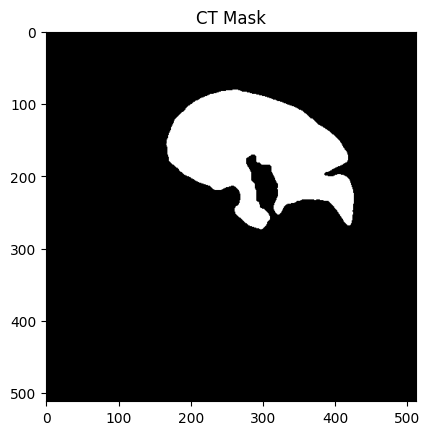

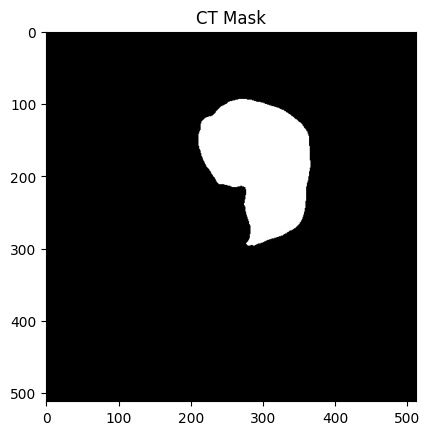

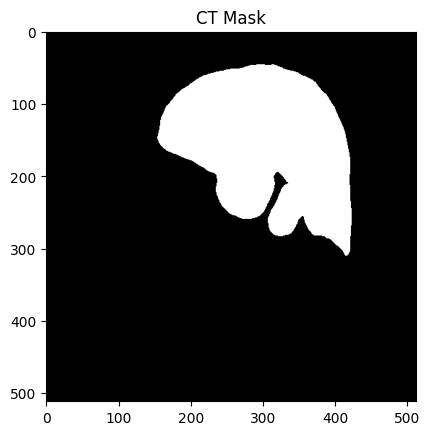

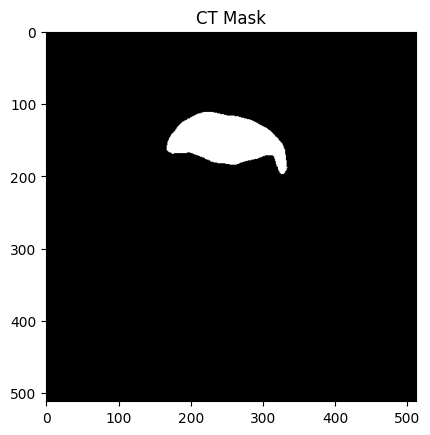

(512, 512)


In [ ]:
#CT mask images
for f in range(len(ff_train)):
    if 'liver' in ff_train[f]:
      a = nib.load(ff_train[f])
      a = a.get_data()
      a = a[:,:,80]
      plt.imshow(a[:, :], cmap='gray')
      plt.title('CT Mask')
      plt.show()
print (a.shape)

<ipython-input-6-e7aaa8c8e0a2>:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  a = a.get_data()


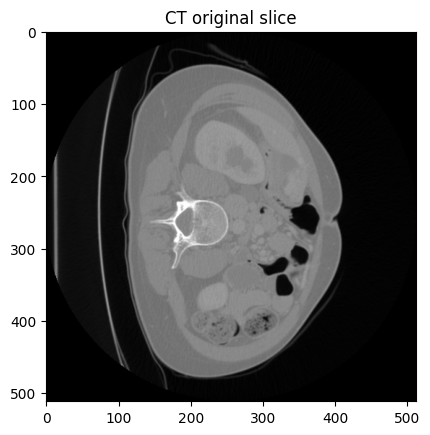

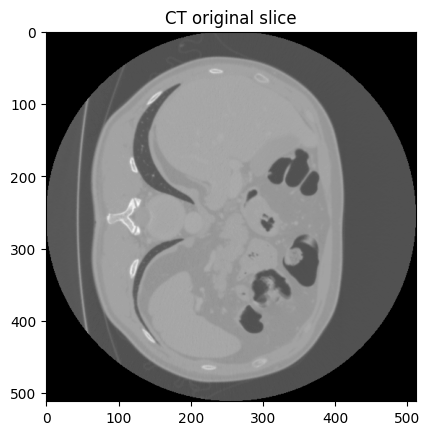

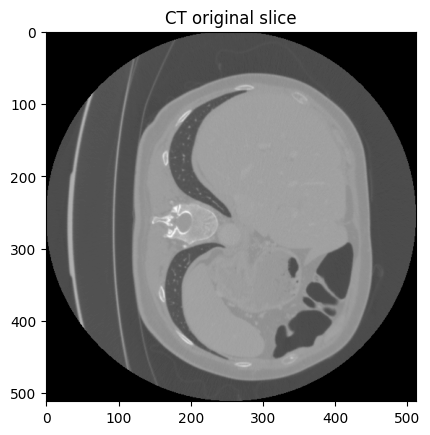

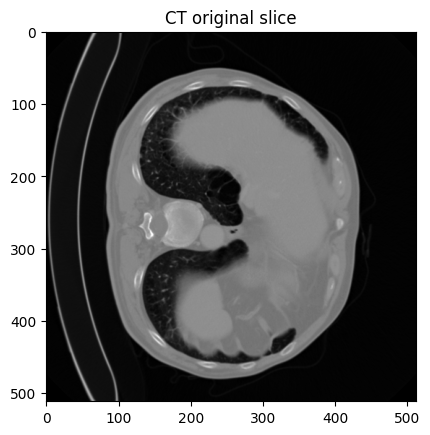

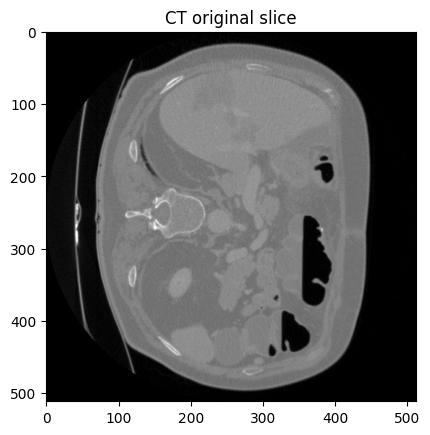

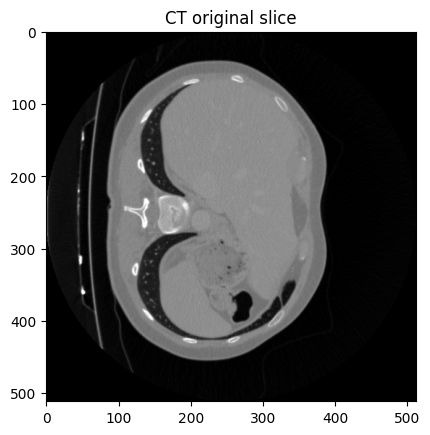

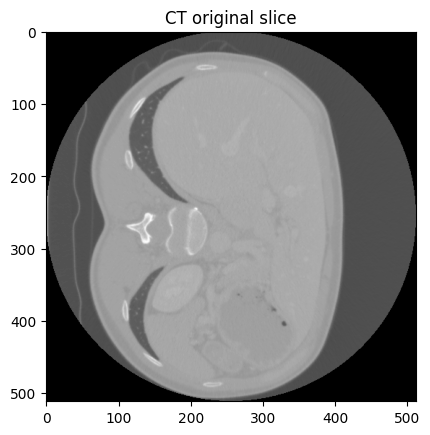

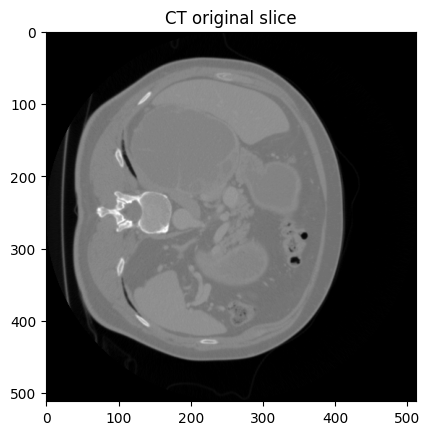

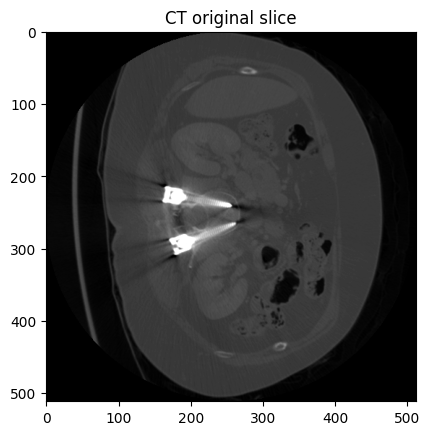

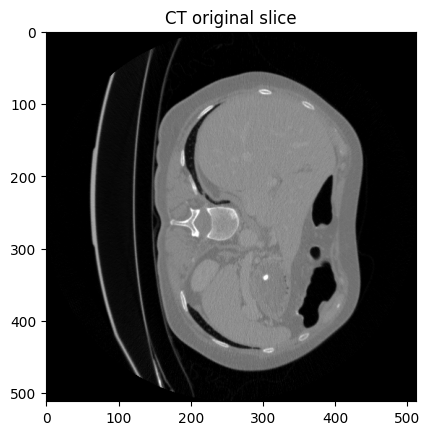

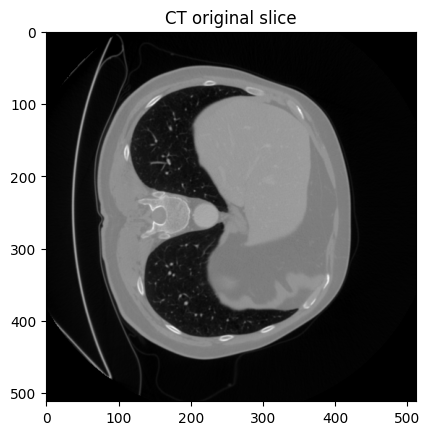

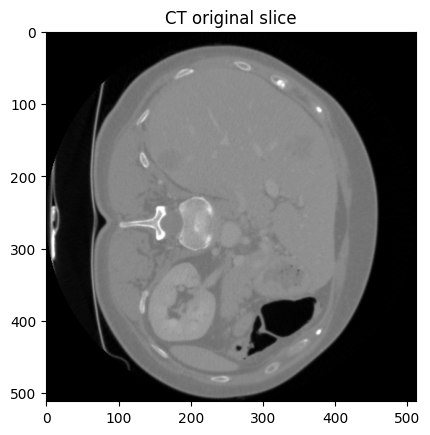

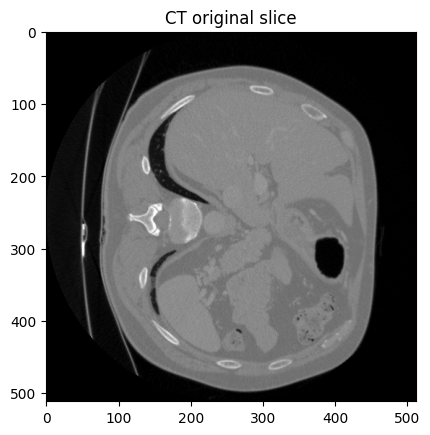

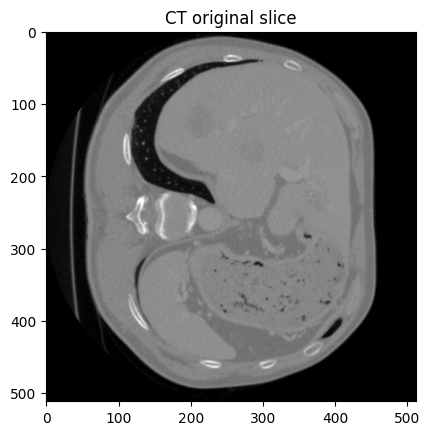

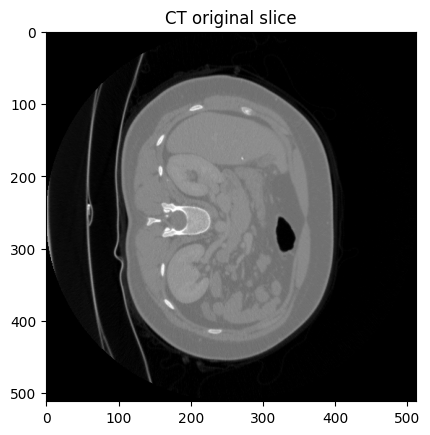

(512, 512)


In [ ]:
#CT original image slices
for f in range(len(ff_train)):
    if 'orig' in ff_train[f]:
      a = nib.load(ff_train[f])
      a = a.get_data()
      a = a[:,:,80]
      plt.imshow(a[:, :], cmap='gray')
      plt.title('CT original slice')
      plt.show()
print (a.shape)

# Data Preprocessing


> **NiiDataProcessor** : is a custom data generator class designed for deep learning model training and testing. It inherits from the TensorFlow's tf.keras.utils.Sequence class, making it easy to load data in batches. When creating an instance of this class, you need to provide four arguments: image_filenames, mask_filenames, batch_size, and image_size. These parameters represent the file paths for images, corresponding masks, the desired batch size, and the target image size, respectively. The class implements two essential methods required by the Sequence class: len() and getitem().

> **len()** method calculates and returns the total number of batches in the data generator, which is determined by dividing the number of images by the batch size and rounding up to the nearest whole number.

> **getitem(idx)** method loads and returns a single batch of data, with idx representing the index of the batch to be loaded. It loads image and mask files using the nibabel library, extracts data from the image object, randomly selects one slice from the volume, resizes the image and mask to the specified dimensions, and returns the data as a tuple in the format (x, y).

> It's important to note that this data generator is designed to work with NIfTI file format, where each image volume consists of a stack of 2D slices. During each iteration, the generator loads a random slice from the stack.

In [8]:
import numpy as np
import nibabel as nib
import random
from glob import glob
import tensorflow as tf

class NiiDataProcessor(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size, image_size):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = (idx + 1) * self.batch_size
        batch_x = self.image_filenames[start_idx:end_idx]
        batch_y = self.mask_filenames[start_idx:end_idx]

        x = np.zeros((self.batch_size, *self.image_size, 1))
        y = np.zeros((self.batch_size, *self.image_size, 1))

        for i, (image_filename, mask_filename) in enumerate(zip(batch_x, batch_y)):
            image = nib.load(image_filename)
            mask = nib.load(mask_filename)
            image_data = image.get_fdata()
            mask_data = mask.get_fdata()
            slice_index = random.randint(0, image_data.shape[2] - 1)
            x[i, :, :, 0] = image_data[:, :, slice_index]
            y[i, :, :, 0] = mask_data[:, :, slice_index]

        return x, y

In [9]:
#check input data
train_im = sorted(glob(os.path.join(data_path, 'train', '*_orig.nii.gz')))
train_msk = sorted(glob(os.path.join(data_path, 'train', '*_liver.nii.gz')))

b_size = 1
i_size = (512, 512)

train_processed = NiiDataProcessor(train_im[:10], train_msk[:10], b_size, i_size)
val_processed = NiiDataProcessor(train_im[10:], train_msk[10:], b_size, i_size)

In [10]:
train_i = sorted(glob(os.path.join(data_path, 'train', '*_orig.nii.gz')))
train_m = sorted(glob(os.path.join(data_path, 'train', '*_liver.nii.gz')))
train_processor = NiiDataProcessor(train_i, train_m, b_size, i_size)
train_img, train_mask = next(iter(train_processor))

In [11]:
print(train_img.shape)
print(train_mask.shape)

(1, 512, 512, 1)
(1, 512, 512, 1)


In [12]:
type(train_img)

numpy.ndarray

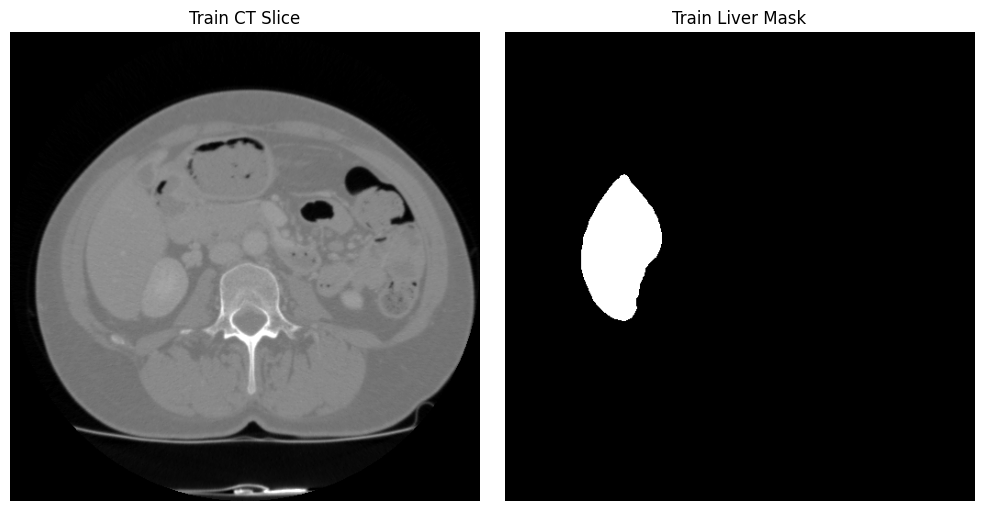

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Train CT Slice')
plt.imshow(np.rot90(train_img[0,...,0], 1), cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Train Liver Mask')
plt.imshow(np.rot90(train_mask[0,...,0], 1), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Unet


**UNet Model Definition**

* we will implement a UNet model, a well-known deep learning architecture often used in semantic segmentation tasks such as liver segmentation.

* First, we define two essential functions: "encoder" and "decoder."

* **encoder**
> * function is responsible for creating the encoding part of the UNet model.
> * It takes inputs, the number of filters, and the pool size as arguments.
> * This encoder consists of a 2D convolutional layer with a (3,3) kernel size, ReLU activation, and 'same' padding, followed by a max-pooling layer with the specified pool size.

* **encoder**
> * function, on the other hand, is designed to create the decoding part of the UNet model.
> * It takes inputs, concatenation input, the number of filters, and the transpose size.
> * This process starts by concatenating the decoder's input with the output from the corresponding encoder layer.
> * Then, it applies a transposed convolutional layer with a kernel size of "transpose_size," a stride of (2,2), and 'same' padding. Following that, it utilizes a 2D convolutional layer with the same parameters as the encoder function.

* Moving forward, we define the primary "UNet" function. It commences by creating an input layer with the provided "img_size," which represents the desired input shape of the images (defaulting to (512,512,1)).

* The function proceeds through four encoder blocks by invoking the "encoder" function and providing the outputs of previous blocks as inputs. In each block, the number of filters and pool size is incremented. A bottleneck is formed by applying a convolutional layer with 512 filters, a kernel size of (3,3), and a ReLU activation function.

* Subsequently, the function employs the bottleneck output and goes through four decoder blocks by utilizing the "decoder" function. In each block, the number of filters is reduced. Each decoder block takes the output of the previous block as input and concatenates it with the output of the corresponding encoder block.

* the function applies a final convolutional layer with 1 filter, a kernel size of (1,1), and a sigmoid activation function to generate the model's output.

* The final step involves creating a Keras model object by specifying the inputs and outputs and returning it. This results in an instance of the UNet model, which can be used for training, evaluation, and making predictions.

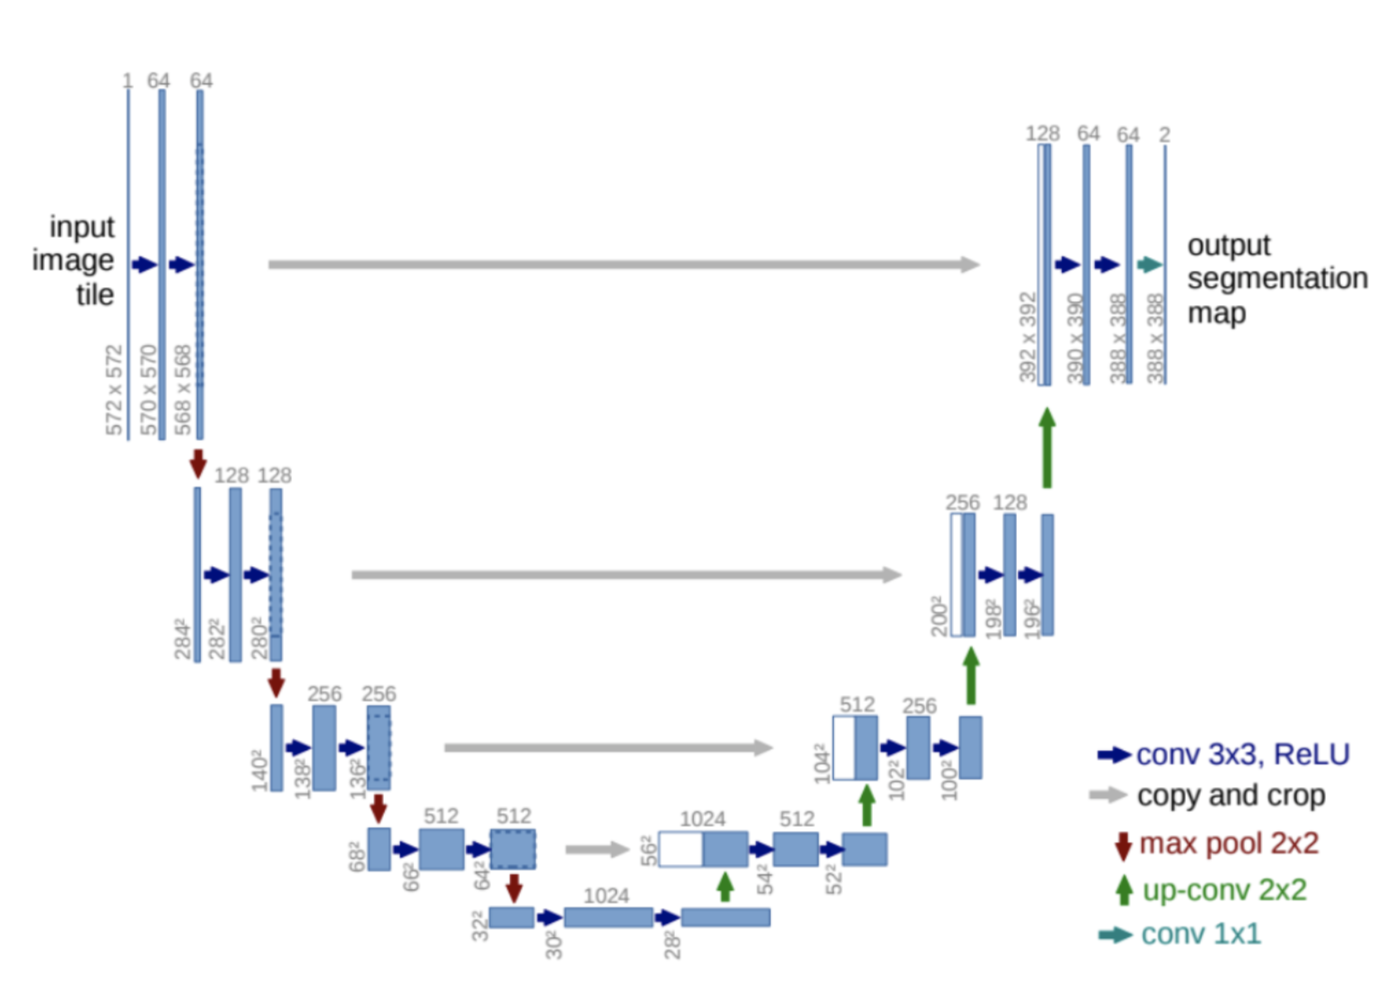

In [13]:
def encoder_unet(inputs, filters, pool_size):
    conv = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    conv = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(conv)
    return conv

def decoder_unet(inputs, concat_input, filters, transpose_size):
    up = tf.keras.layers.Concatenate()([tf.keras.layers.Conv2DTranspose(filters, transpose_size, strides=(2, 2), padding='same')(inputs), concat_input])
    up = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(up)
    return up


In [14]:
def UNet(im_size=(512,512,1)):
    inp = tf.keras.Input(im_size)
    # Encoder
    conv_p1 = encoder_unet(inp, 32, (2, 2))
    conv_p2 = encoder_unet(conv_p1, 64, (2, 2))
    conv_p3 = encoder_unet(conv_p2, 128, (2, 2))
    conv_p4 = encoder_unet(conv_p3, 256, (2, 2))
    # Bottleneck
    bridge = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv_p4)
    #Decoder
    up_p6 = decoder_unet(bridge, conv_p3, 256, (2, 2))
    up_p7 = decoder_unet(up_p6, conv_p2, 128, (2, 2))
    up_p8 = decoder_unet(up_p7, conv_p1, 64, (2, 2))
    up_p9 = decoder_unet(up_p8, inp, 32, (2, 2))
    outp = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(up_p9)
    model = tf.keras.Model(inputs=[inp], outputs=[outp])
    return model

model = UNet()

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         18496     ['max_pooling2d[0][0]']   

# Dice Coefficient

> * Dice coefficient and its application as a metric for evaluating the performance of semantic segmentation models, such as UNet.

The formula for the Dice coefficient is:

Dice = (2 * |A ∩ B|) / (|A| + |B|)

Where:

A is the first set (e.g., the ground truth or target set).
B is the second set (e.g., the predicted or segmented set).
|A ∩ B| represents the cardinality (number of elements) of the intersection of sets A and B.
|A| and |B| represent the cardinality of sets A and B, respectively.

> * The Dice coefficient, also known as the Sørensen-Dice coefficient, serves as a widely employed metric for assessing the performance of semantic segmentation models.
> It quantifies the ratio of the intersection of the predicted segmentation and the ground truth segmentation to their union.

> * To compute the Dice coefficient, we will define a function called `dice_coef`, which takes two arguments: `y_true` and `y_pred`, representing the ground truth and predicted segmentations, respectively.

> * The function begins by flattening the `y_true` and `y_pred` inputs into 1-D arrays using the `tf.keras.backend.flatten` function. Subsequently, it calculates the intersection of the true and predicted segmentations by taking the element-wise product of the flattened `y_true` and `y_pred` and then summing the resulting array.

> * the Dice coefficient is computed by dividing twice the intersection by the sum of the flattened `y_true` and `y_pred`, along with the inclusion of a smoothing term. This smoothing term is introduced by adding a small value to both the numerator and denominator to prevent division by zero errors.

> * The Dice coefficient calculation results in a scalar value ranging from 0 to 1, with values closer to 1 indicating superior segmentation performance. Utilizing the Dice coefficient as a metric offers a robust means of evaluating model performance. A higher Dice coefficient indicates better segmentation accuracy.

In [15]:
def dice_coef(y_true, y_pred, smooth=1.):
  y_true_f = tf.keras.backend.flatten(y_true)
  y_pred_f = tf.keras.backend.flatten(y_pred)
  intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

> * With our UNet model defined and the dice coefficient metric implemented, we are now ready to train the model. We can begin by compiling the model by specifying the loss function and optimizer. In this case, we will be using the binary cross entropy loss as it is commonly used for binary classification tasks.

> * Next, we will train the model using our training data. During training, we will monitor the performance of the model on the validation data using the dice similarity coefficient as a metric. This will give us an insight on how the model is performing on unseen data.

> * Finally, we will train the model for 100 epochs and save the best model based on performance on the validation data. This will ensure that we are using the best performing model for predictions and further analysis.

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='bce', metrics=[dice_coef])

cp = ModelCheckpoint('best_unet_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(train_processor,
                              steps_per_epoch=len(train_processor),
                              epochs=10,
                              validation_data=val_processed,
                              validation_steps=len(val_processed),
                              callbacks=[cp])

Epoch 1/10
15/15 [==============================] - 104s 7s/step - loss: 3.6769 - dice_coef: 0.1884 - val_loss: 0.2778 - val_dice_coef: 0.0713


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
15/15 [==============================] - 81s 5s/step - loss: 0.3589 - dice_coef: 0.2081 - val_loss: 0.4075 - val_dice_coef: 0.1732
Epoch 3/10
15/15 [==============================] - 90s 6s/step - loss: 0.2698 - dice_coef: 0.1528 - val_loss: 0.3886 - val_dice_coef: 0.0474
Epoch 4/10
15/15 [==============================] - 80s 5s/step - loss: 0.2356 - dice_coef: 0.1021 - val_loss: 0.3459 - val_dice_coef: 0.1123
Epoch 5/10
15/15 [==============================] - 78s 5s/step - loss: 0.1945 - dice_coef: 0.1172 - val_loss: 0.2031 - val_dice_coef: 0.4135
Epoch 6/10
15/15 [==============================] - 81s 5s/step - loss: 0.2019 - dice_coef: 0.1000 - val_loss: 0.2353 - val_dice_coef: 0.2916
Epoch 7/10
15/15 [==============================] - 83s 5s/step - loss: 0.2084 - dice_coef: 0.1432 - val_loss: 0.1969 - val_dice_coef: 0.4718
Epoch 8/10
15/15 [==============================] - 80s 5s/step - loss: 0.2178 - dice_coef: 0.3334 - val_loss: 0.2933 - val_dice_coef: 0.3511
Epoch 

> * After completing the training process, it becomes crucial to assess the model's performance. One common approach is to visualize the training and validation losses, along with the Dice scores. This visual analysis provides valuable insights into how the model has performed during the training phase.

> *  It's worth mentioning that during training, the training loss tends to decrease, and the Dice score usually improves. However, it's possible that the validation loss and Dice score do not consistently show improvement.

In [19]:
import plotly.graph_objs as go
import plotly.subplots as sp

# Create a subplot with two subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("BCE Losses", "Dice Score"))

# Add the loss curves to the first subplot
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)), y=history.history['loss'], name='Train', mode='lines', line=dict(color='green')), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)), y=history.history['val_loss'], name='Val.', mode='lines'), row=1, col=1)

# Add the Dice score curves to the second subplot
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['dice_coef']) + 1)), y=history.history['dice_coef'], name='Train', mode='lines', line=dict(color='red')), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_dice_coef']) + 1)), y=history.history['val_dice_coef'], name='Val.', mode='lines'), row=1, col=2)

# Update the layout
fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)
fig.update_yaxes(title_text="Losses", row=1, col=1)
fig.update_yaxes(title_text="Dice Score", row=1, col=2)
fig.update_layout(title_text="Training Progress", showlegend=True)

# Show the plot
fig.show()


In [20]:
model.load_weights('/content/best_unet_model.h5')

In [21]:
test_i = sorted(glob(os.path.join(data_path, 'test', '*_orig.nii.gz')))
test_m = sorted(glob(os.path.join(data_path, 'test', '*_liver.nii.gz')))

test_processor = NiiDataProcessor(test_i, test_m, b_size, i_size)

test_img, test_mask = next(iter(test_processor))

test_pred = model.predict(test_img)
test_pred_thresh = (test_pred[0,...,0] >= 0.5).astype(np.uint8)

1/1 [==============================] - 2s 2s/step


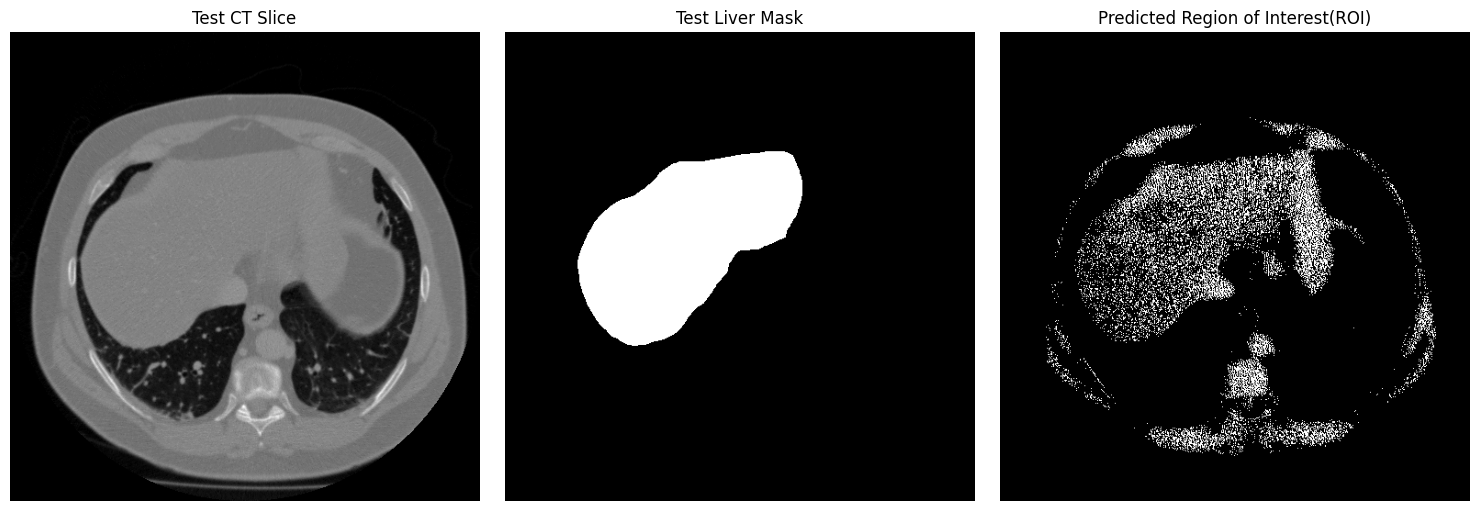

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Test CT Slice')
plt.imshow(np.rot90(test_img[0,...,0], 1), cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Test Liver Mask')
plt.imshow(np.rot90(test_mask[0,...,0], 1), cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.title('Predicted Region of Interest(ROI)')
plt.imshow(np.rot90(test_pred_thresh, 1), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
model2 = UNet()
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='bce', metrics=[dice_coef])

cp = ModelCheckpoint('best_unet_model1.h5', monitor='val_loss', save_best_only=True)

history = model2.fit(train_processor,
                              steps_per_epoch=len(train_processor),
                              epochs=250,
                              validation_data=val_processed,
                              validation_steps=len(val_processed),
                              callbacks=[cp])

Epoch 1/250
15/15 [==============================] - ETA: 0s - loss: 16.3293 - dice_coef: 0.1176

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 102s 6s/step - loss: 16.3293 - dice_coef: 0.1176 - val_loss: 0.3989 - val_dice_coef: 0.0445
Epoch 2/250
15/15 [==============================] - 100s 7s/step - loss: 0.4353 - dice_coef: 0.2695 - val_loss: 0.2918 - val_dice_coef: 0.2104
Epoch 3/250
15/15 [==============================] - 100s 7s/step - loss: 0.3364 - dice_coef: 0.1979 - val_loss: 0.3390 - val_dice_coef: 0.4321
Epoch 4/250
15/15 [==============================] - 91s 6s/step - loss: 0.2227 - dice_coef: 0.1261 - val_loss: 0.1011 - val_dice_coef: 0.0623
Epoch 5/250
15/15 [==============================] - 107s 7s/step - loss: 0.2106 - dice_coef: 0.0801 - val_loss: 0.2715 - val_dice_coef: 0.0236
Epoch 6/250
15/15 [==============================] - 101s 7s/step - loss: 0.2874 - dice_coef: 0.2299 - val_loss: 0.2805 - val_dice_coef: 0.1554
Epoch 7/250
15/15 [==============================] - 136s 9s/step - loss: 0.1075 - dice_coef: 0.1515 - val_loss: 0.2402 - val_dice_coef: 0.0506
Epoc

In [ ]:
import plotly.graph_objs as go
import plotly.subplots as sp

# Create a subplot with two subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("BCE Losses", "Dice Score"))

# Add the loss curves to the first subplot
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)), y=history.history['loss'], name='Train', mode='lines', line=dict(color='green')), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)), y=history.history['val_loss'], name='Val.', mode='lines'), row=1, col=1)

# Add the Dice score curves to the second subplot
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['dice_coef']) + 1)), y=history.history['dice_coef'], name='Train', mode='lines', line=dict(color='red')), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_dice_coef']) + 1)), y=history.history['val_dice_coef'], name='Val.', mode='lines'), row=1, col=2)

# Update the layout
fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)
fig.update_yaxes(title_text="Losses", row=1, col=1)
fig.update_yaxes(title_text="Dice Score", row=1, col=2)
fig.update_layout(title_text="Training Progress", showlegend=True)

# Show the plot
fig.show()

In [ ]:
model.load_weights('/content/best_unet_model2.h5')

In [ ]:
test_i = sorted(glob(os.path.join(data_path, 'test', '*_orig.nii.gz')))
test_m = sorted(glob(os.path.join(data_path, 'test', '*_liver.nii.gz')))

test_processor = NiiDataProcessor(test_i, test_m, b_size, i_size)

test_img, test_mask = next(iter(test_processor))

test_pred = model2.predict(test_img)
test_pred_thresh = (test_pred[0,...,0] >= 0.5).astype(np.uint8)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Test CT Slice')
plt.imshow(np.rot90(test_img[0,...,0], 1), cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Test Liver Mask')
plt.imshow(np.rot90(test_mask[0,...,0], 1), cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.title('Predicted Region of Interest(ROI)')
plt.imshow(np.rot90(test_pred_thresh, 1), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()